In [1]:
import sys
sys.path.append('../../../')

In [2]:
from win10toast import ToastNotifier
toast = ToastNotifier()

In [3]:
import torch
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange

from models.train_reg import train, test
from models.models import GCN, GAT, GraphSAGE, FNN
from models.utils import ContagionDataset, set_seed
from sklearn.metrics import matthews_corrcoef, mean_squared_error, mean_absolute_error

Using backend: pytorch


In [4]:
def pretty(ld, indent=0):
    with open('result.txt', 'w', encoding='utf-8') as file:
        for d in tqdm(ld):
            file.write('{' + '\n')
            for key, value in d.items():
                file.write('\t' * (indent+1) + str(key) + ':' + str(value) + '\n')
                # file.write('\t' * (indent+1) + str(key) + '\n')
                # file.write('\t' * (indent+2) + str(value) + '\n')
            file.write('},\n')

In [5]:
do_train = True

seed = 4444
set_seed(seed)

metric_filter_1 = 'val_rmse_perc'
metric_filter_2 = 'test_rmse_perc'

data_dir = '../data'
log_path = './logs'
save_path = './saved'

# Big dataset: Additional stress

In [6]:
sets_lengths = (0.5, 0.25, 0.25)
target = 'additional_stress'

dataset = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    target = target,
)

out_feats = 1

## Baseline

### FNN

In [7]:
save_model = f'{save_path}_fnn'
log_dir = f'{log_path}_fnn'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = False,
    target = target,
)

# fnn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[5, 10], [10, 15], [5,5,5], [5, 10, 15], [5, 10, 15, 20], [5], [10], [15]],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_nodes = [None, 'bn', 'gn'],
#     dropout=[0.2, 0.5, 0.0],
#     # other
#     lr=[1, 1e-1, 1e-2],
#     label_smoothing=[0.0, 0.2, 0.4],
# )

fnn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[10, 15], [10, 15, 20], [5, 10, 15], [15] * 2, [15] * 3],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_nodes = [None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
)
list_model = [dict(zip(fnn_model.keys(), k)) for k in itertools.product(*fnn_model.values())]

In [8]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')

        train(
            model=FNN(**d),
            dict_model=d,
            dataset_train=dataset_val,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=False,
            loss_type='mse',
        )

100%|██████████| 30/30 [02:41<00:00,  5.39s/it]


#### Results

In [9]:
res_edges_fnn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 525/525 [00:28<00:00, 18.43it/s]


In [10]:
res_edges = res_edges_fnn
res_edges[0]

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': None,
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale-dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'val_mcc': 0.37598127199319553,
 'epoch': 100,
 'train_loss': 0.57958424,
 'val_loss': 0.6017941,
 'train_acc': 0.5093333125114441,
 'val_acc': 0.4906666576862335,
 'val_rmse_perc': 0.20841762,
 'model_class': 'fnn',
 'path_name': 'saved_fnn\\0.49_4_[10_15_20]_4_ReLU()_None_0.0_0.1_adamw_max_val_mcc_False_mse_scale-dist_10_False_0_100',
 'train_rmse': 0.8786353054595518,
 'val_rmse': 0.8884443332777431,
 'test_rmse': 0.9062744249582095,
 'train_mae': 0.5826666666666667,
 'val_mae': 0.6026666666666667,
 'test_mae': 0.5866666666666667,
 'train_mcc': 0.37934793280118606,
 'test_mcc': 0.4156

In [11]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': None,
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale-dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'val_mcc': 0.37648100595034956,
 'epoch': 64,
 'train_loss': 0.5907692,
 'val_loss': 0.6005411,
 'train_acc': 0.5053333044052124,
 'val_acc': 0.48266667127609253,
 'val_rmse_perc': 0.20619395,
 'model_class': 'fnn',
 'path_name': 'saved_fnn\\0.48_4_[10_15_20]_4_ReLU()_None_0.0_0.1_adamw_max_val_mcc_False_mse_scale-dist_10_False_0',
 'train_rmse': 0.8633268983029159,
 'val_rmse': 0.8884443332777431,
 'test_rmse': 0.8929352346801717,
 'train_mae': 0.5773333333333334,
 'val_mae': 0.608,
 'test_mae': 0.584,
 'train_mcc': 0.38263100426250385,
 'test_mcc': 0.40988358984856005,
 'test_acc': 0.5

In [12]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale-dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'val_mcc': 0.32182296446263453,
 'epoch': 90,
 'train_loss': 0.56682545,
 'val_loss': 0.60056174,
 'train_acc': 0.5106666684150696,
 'val_acc': 0.47999998927116394,
 'val_rmse_perc': 0.20787868,
 'model_class': 'fnn',
 'path_name': 'saved_fnn\\0.48_4_[15_15_15]_4_ReLU()_bn_0.0_0.1_adamw_max_val_mcc_False_mse_scale-dist_10_False_0_90',
 'train_rmse': 0.8366600265340756,
 'val_rmse': 0.8390470785361213,
 'test_rmse': 0.816496580927726,
 'train_mae': 0.5586666666666666,
 'val_mae': 0.5813333333333334,
 'test_mae': 0.5546666666666666,
 'train_mcc': 0.3545047738602865,
 'test_mcc': 0.34068876

In [13]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 525/525 [00:00<00:00, 19496.13it/s]


In [14]:
cm = all[sort_idx[0]]['test_cm'][0]

In [15]:
(cm.labels==0).sum()

tensor(98)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

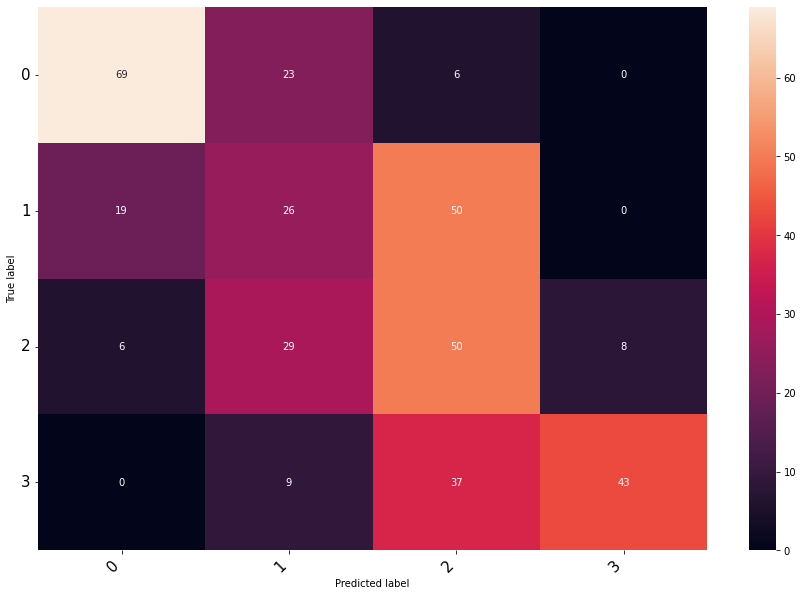

In [16]:
cm.visualize()

In [17]:
cm.class_accuracy

tensor([0.7041, 0.2737, 0.5376, 0.4831])

In [18]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.16033658, 0.22508544, 0.19788547, 0.20236926]

In [19]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.11796341, 0.1991996, 0.1547164, 0.17116906]

### GCN

In [20]:
save_model = f'{save_path}_gcn'
log_dir = f'{log_path}_gcn'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gcn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[15] * 3, [10, 15, 20], [5, 10, 15, 20],],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_edges=['both', 'none'],
    norm_nodes=[None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
    use_edge_weight=[True,],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gcn_model.keys(), k)) for k in itertools.product(*gcn_model.values())]

# gcn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[10] * 3],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_edges=['both', 'none'],
#     norm_nodes=[None, 'bn', 'gn'],
#     dropout=[0.2, 0.0],
#     # other
#     lr=[1],
#     label_smoothing=[0.0,],
#     use_edge_weight=[True, ],
#     drop_edges=[0,0.2],
# )
# list_model = [{i:j[k] for i,j in gcn_model.items()} for k in range(len(gcn_model['in_features']))]

In [21]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GCN(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 72/72 [09:59<00:00,  8.32s/it]


#### Results

In [22]:
res_edges_gcn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 1101/1101 [01:21<00:00, 13.44it/s]


In [23]:
res_edges = res_edges_gcn
res_edges[0]

{'in_features': 4,
 'h_features': [5, 10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': None,
 'dropout': 0.2,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale-dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.3484880325306321,
 'epoch': 30,
 'train_loss': 0.8792224,
 'val_loss': 0.69232464,
 'train_acc': 0.4359999895095825,
 'val_acc': 0.4266666769981384,
 'val_rmse_perc': 0.22169994,
 'model_class': 'gcn',
 'path_name': 'saved_gcn\\0.43_4_[5_10_15_20]_4_ReLU()_none_None_0.2_0.1_adamw_max_val_mcc_True_mse_scale-dist_10_True_0',
 'train_rmse': 0.9309493362512627,
 'val_rmse': 0.9033271832508971,
 'test_rmse': 0.9323804659758447,
 'train_mae': 0.656,
 'val_mae': 0.6506666666666666,
 'test_mae': 0.64,
 'train_mcc': 0.32768534824032286,
 'test_mcc': 0.34920001

In [24]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale-dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.32007822021811305,
 'epoch': 100,
 'train_loss': 0.6502224,
 'val_loss': 0.64453757,
 'train_acc': 0.4333333373069763,
 'val_acc': 0.41866666078567505,
 'val_rmse_perc': 0.21234815,
 'model_class': 'gcn',
 'path_name': 'saved_gcn\\0.42_4_[10_15_20]_4_ReLU()_none_bn_0.0_0.1_adamw_max_val_mcc_True_mse_scale-dist_10_True_0_100',
 'train_rmse': 0.866410218468519,
 'val_rmse': 0.8793937305515279,
 'test_rmse': 0.8763560920082658,
 'train_mae': 0.628,
 'val_mae': 0.6453333333333333,
 'test_mae': 0.64,
 'train_mcc': 0.3188410709870008,
 'test_mcc': 0.2956433241

In [25]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale-dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.3135583713608666,
 'epoch': 80,
 'train_loss': 0.6502232,
 'val_loss': 0.6488489,
 'train_acc': 0.43066665530204773,
 'val_acc': 0.41333332657814026,
 'val_rmse_perc': 0.21296531,
 'model_class': 'gcn',
 'path_name': 'saved_gcn\\0.41_4_[10_15_20]_4_ReLU()_none_bn_0.0_0.1_adamw_max_val_mcc_True_mse_scale-dist_10_True_0_80',
 'train_rmse': 0.8679477710861024,
 'val_rmse': 0.8824209124146292,
 'test_rmse': 0.8733078876700168,
 'train_mae': 0.6306666666666667,
 'val_mae': 0.6506666666666666,
 'test_mae': 0.64,
 'train_mcc': 0.3149320993207251,
 'test_mcc': 0

In [26]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 1101/1101 [00:00<00:00, 19367.34it/s]


### GraphSAGE

In [27]:
save_model = f'{save_path}_sage_dist'
log_dir = f'{log_path}_sage_dist'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[20] * 3, [25] * 3, [15] * 3, [10], [20,25,20], [30] * 3], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [28]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 144/144 [4:19:44<00:00, 108.22s/it]  


#### Results

In [29]:
res_edges_sage = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

toast.show_toast("Done")

100%|██████████| 2814/2814 [20:19<00:00,  2.31it/s]


True

In [30]:
res_edges = res_edges_sage
res_edges[0]

{'in_features': 4,
 'h_features': [30, 30, 30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale-dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.6851880886237376,
 'epoch': 68,
 'train_loss': 0.109339006,
 'val_loss': 0.17635827,
 'train_acc': 0.8640000224113464,
 'val_acc': 0.7599999904632568,
 'val_rmse_perc': 0.10273165,
 'model_class': 'sage',
 'path_name': 'saved_sage_dist\\0.76_4_[30_30_30]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_scale-dist_10_True_0',
 'train_rmse': 0.3794733192202055,
 'val_rmse': 0.5138093031466052,
 'test_rmse': 0.4844240566555987,
 'train_mae': 0.13866666666666666,
 'val_mae': 0.248,
 'test_mae': 0.192,
 'train_mcc': 0.82158

In [31]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale-dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.7691548979213838,
 'epoch': 70,
 'train_loss': 0.21638395,
 'val_loss': 0.13449012,
 'train_acc': 0.8666666746139526,
 'val_acc': 0.8266666531562805,
 'val_rmse_perc': 0.08473763,
 'model_class': 'sage',
 'path_name': 'saved_sage_dist\\0.83_4_[15_15_15]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_scale-dist_10_True_0.2_70',
 'train_rmse': 0.3651483716701107,
 'val_rmse': 0.41633319989322654,
 'test_rmse': 0.5316640543300503,
 'train_mae': 0.13333333333333333,
 'val_mae': 0.17333333333333334,
 'test_mae': 0.23466

In [32]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20, 25, 20],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale-dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.7749684471984493,
 'epoch': 89,
 'train_loss': 0.23857647,
 'val_loss': 0.14836058,
 'train_acc': 0.8573333621025085,
 'val_acc': 0.8293333053588867,
 'val_rmse_perc': 0.08985975,
 'model_class': 'sage',
 'path_name': 'saved_sage_dist\\0.83_4_[20_25_20]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_scale-dist_10_True_0.2',
 'train_rmse': 0.4131182235954578,
 'val_rmse': 0.4412104562073146,
 'test_rmse': 0.508592829940284,
 'train_mae': 0.152,
 'val_mae': 0.17866666666666667,
 'test_mae': 0.23733333333333334,
 'tra

In [33]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 2814/2814 [00:00<00:00, 23512.86it/s]


#### cm

In [34]:
cm = all[sort_idx[0]]['test_cm'][0]

In [35]:
(cm.labels==0).sum()

tensor(98)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

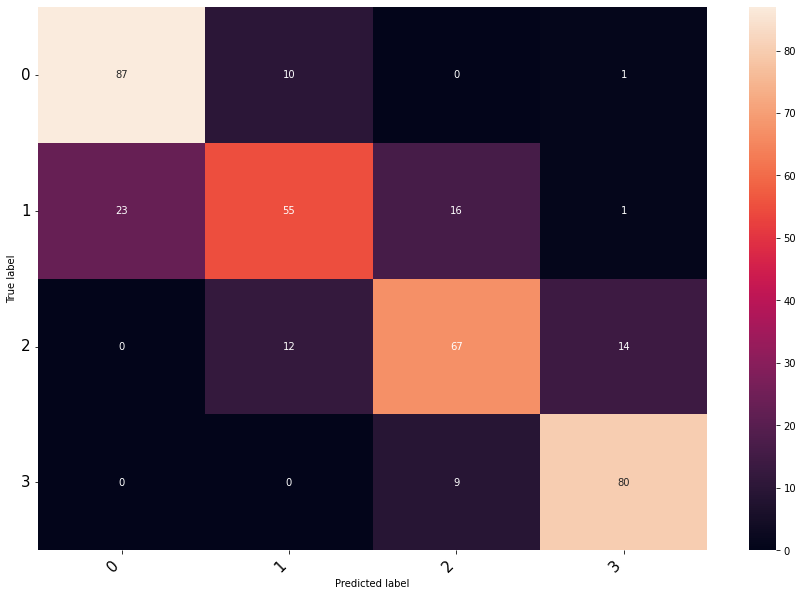

In [36]:
cm.visualize()

In [37]:
cm.class_accuracy

tensor([0.8878, 0.5789, 0.7204, 0.8989])

In [38]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.09282109, 0.12385958, 0.08869572, 0.07439641]

In [39]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.060956735, 0.089074776, 0.06343372, 0.051185995]

#### GraphSAGE Base_n

In [40]:
save_model = f'{save_path}_sage_base'
log_dir = f'{log_path}_sage_base'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[20] * 3, [25] * 3, [15] * 3, [10], [20,25,20], [30] * 3], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [41]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
            approach='base_n',
        )

100%|██████████| 144/144 [4:04:41<00:00, 101.95s/it] 


##### Results

In [42]:
res_edges_sage_base = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
    approach_default='base_n',
)

toast.show_toast("Done")

100%|██████████| 2342/2342 [18:15<00:00,  2.14it/s]


True

In [43]:
res_edges = res_edges_sage_base
res_edges[0]

{'in_features': 4,
 'h_features': [30, 30, 30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'base_n',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.6679276690300934,
 'epoch': 62,
 'train_loss': 0.055356912,
 'val_loss': 0.24235834,
 'train_acc': 0.7893333435058594,
 'val_acc': 0.7413333058357239,
 'val_rmse_perc': 0.11275362,
 'model_class': 'sage',
 'path_name': 'saved_sage_base\\0.74_4_[30_30_30]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_base_n_10_True_0',
 'train_rmse': 0.4633213427705081,
 'val_rmse': 0.5316640543300503,
 'test_rmse': 0.5865151319446071,
 'train_mae': 0.212,
 'val_mae': 0.26666666666666666,
 'test_mae': 0.32266666666666666,
 'train_mcc': 0

In [44]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [30, 30, 30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'base_n',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.6679276690300934,
 'epoch': 62,
 'train_loss': 0.055356912,
 'val_loss': 0.24235834,
 'train_acc': 0.7893333435058594,
 'val_acc': 0.7413333058357239,
 'val_rmse_perc': 0.11275362,
 'model_class': 'sage',
 'path_name': 'saved_sage_base\\0.74_4_[30_30_30]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_base_n_10_True_0',
 'train_rmse': 0.4633213427705081,
 'val_rmse': 0.5316640543300503,
 'test_rmse': 0.5865151319446071,
 'train_mae': 0.212,
 'val_mae': 0.26666666666666666,
 'test_mae': 0.32266666666666666,
 'train_mcc': 0

In [45]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'base_n',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.6017847649067767,
 'epoch': 55,
 'train_loss': 0.10017315,
 'val_loss': 0.3278769,
 'train_acc': 0.6986666917800903,
 'val_acc': 0.6826666593551636,
 'val_rmse_perc': 0.115343615,
 'model_class': 'sage',
 'path_name': 'saved_sage_base\\0.68_4_[15_15_15]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_base_n_10_True_0',
 'train_rmse': 0.565685424949238,
 'val_rmse': 0.570379990298865,
 'test_rmse': 0.6239658110292048,
 'train_mae': 0.30666666666666664,
 'val_mae': 0.32,
 'test_mae': 0.37866666666666665,
 'train_mcc': 0.623

In [46]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 2342/2342 [00:00<00:00, 18345.81it/s]


##### cm

In [47]:
cm = all[sort_idx[0]]['test_cm'][0]

In [48]:
(cm.labels==0).sum()

tensor(98)

In [49]:
cm.pseudo_perc.max()

tensor(0.9976)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

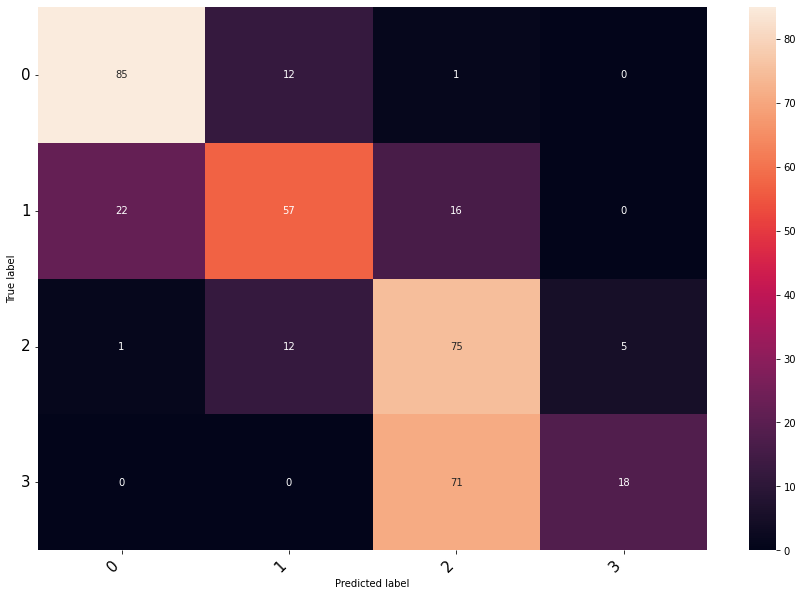

In [50]:
cm.visualize()

In [51]:
cm.class_accuracy

tensor([0.8673, 0.6000, 0.8065, 0.2022])

In [52]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.08915211, 0.12106908, 0.08959176, 0.17894426]

In [53]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.06501005, 0.0985591, 0.058360793, 0.1545213]

#### GraphSAGE Scale

In [54]:
save_model = f'{save_path}_sage_scale'
log_dir = f'{log_path}_sage_scale'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[20] * 3, [25] * 3, [15] * 3, [10], [20,25,20], [30] * 3], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [55]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
            approach='scale',
        )

100%|██████████| 144/144 [3:52:33<00:00, 96.90s/it]  


##### Results

In [56]:
res_edges_sage_dist = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
    approach_default='scale',
)

toast.show_toast("Done")

100%|██████████| 2763/2763 [13:21<00:00,  3.45it/s]


True

In [57]:
res_edges = res_edges_sage_dist
res_edges[0]

{'in_features': 4,
 'h_features': [20, 20, 20],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.7693170437015883,
 'epoch': 70,
 'train_loss': 0.056047972,
 'val_loss': 0.11937422,
 'train_acc': 0.9133333563804626,
 'val_acc': 0.8213333487510681,
 'val_rmse_perc': 0.10231941,
 'model_class': 'sage',
 'path_name': 'saved_sage_scale\\0.82_4_[20_20_20]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_scale_10_True_0_70',
 'train_rmse': 0.2943920288775949,
 'val_rmse': 0.4412104562073146,
 'test_rmse': 0.518973345494095,
 'train_mae': 0.08666666666666667,
 'val_mae': 0.184,
 'test_mae': 0.20533333333333334,
 'train_mcc': 

In [58]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [30, 30, 30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.7536524557923355,
 'epoch': 80,
 'train_loss': 0.2352949,
 'val_loss': 0.13130006,
 'train_acc': 0.8546666502952576,
 'val_acc': 0.8106666803359985,
 'val_rmse_perc': 0.09120667,
 'model_class': 'sage',
 'path_name': 'saved_sage_scale\\0.81_4_[30_30_30]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_scale_10_True_0.2',
 'train_rmse': 0.3812260921465546,
 'val_rmse': 0.44422216663887154,
 'test_rmse': 0.5727128425310541,
 'train_mae': 0.14533333333333334,
 'val_mae': 0.192,
 'test_mae': 0.264,
 'train_mcc': 0.81371098506

In [59]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25, 25, 25],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.7506129662382091,
 'epoch': 33,
 'train_loss': 0.30050182,
 'val_loss': 0.1489976,
 'train_acc': 0.8213333487510681,
 'val_acc': 0.8106666803359985,
 'val_rmse_perc': 0.09722708,
 'model_class': 'sage',
 'path_name': 'saved_sage_scale\\0.81_4_[25_25_25]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_scale_10_True_0.2',
 'train_rmse': 0.44572039067858077,
 'val_rmse': 0.46188021535170065,
 'test_rmse': 0.5316640543300503,
 'train_mae': 0.18533333333333332,
 'val_mae': 0.19733333333333333,
 'test_mae': 0.24,
 'train_mcc':

In [60]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 2763/2763 [00:00<00:00, 23882.69it/s]


##### cm

In [61]:
cm = all[sort_idx[0]]['test_cm'][0]

In [62]:
(cm.labels==0).sum()

tensor(98)

In [63]:
cm.pseudo_perc.max()

tensor(0.9992)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

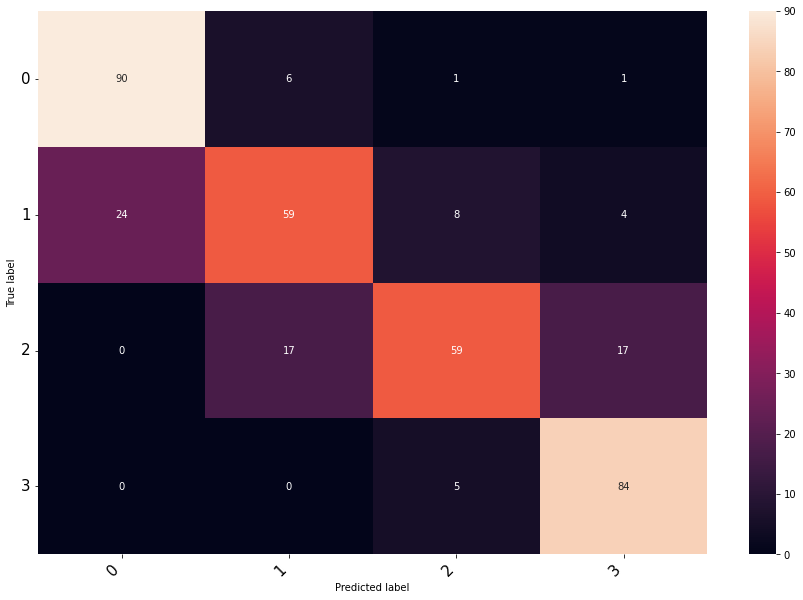

In [64]:
cm.visualize()

In [65]:
cm.class_accuracy

tensor([0.9184, 0.6211, 0.6344, 0.9438])

In [66]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.1103592, 0.14598954, 0.090183005, 0.080373146]

In [67]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.07438476, 0.10999279, 0.06854013, 0.053377017]

### GAT

In [68]:
save_model = f'{save_path}_gat'
log_dir = f'{log_path}_gat'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gat_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[10], [10] * 2, [15], [15] * 2, [20], [20] * 2, [25], [25] * 2],
    out_features = [out_feats],
    num_heads = [[4] * 2, [2] * 2, [4, 2]],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    negative_slope = [0.2, 0.4],
    feat_drop = [0.2],
    attn_drop = [0.2],
    residual = [True],
    # other
    lr=[1e-2,],
    use_edge_weight=[False],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]

# gat_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     # h_features = [[10], [15], [20]], 
#     h_features = [[10] * 3, [15] * 3, [20] * 3], 
#     out_features = [out_feats],
#     # num_heads = [[4] * 4],
#     num_heads = [[4, 2, 2]],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     negative_slope = [0.2, 0.3, 0.4],
#     feat_drop = [0.2],
#     attn_drop = [0.2],
#     residual = [True],
#     # other
#     lr=[1e-2,],
#     label_smoothing=[0.0],
#     use_edge_weight=[False],
#     drop_edges=[0,],
# )
# list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]
# list_model = [{i:j[k] for i,j in gat_model.items()} for k in range(len(gat_model['in_features']))]

In [69]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GAT(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 288/288 [33:01<00:00,  6.88s/it]


#### Results

In [70]:
res_edges_gat = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 5177/5177 [04:27<00:00, 19.35it/s]


In [71]:
res_edges = res_edges_gat
res_edges[0]

{'in_features': 4,
 'h_features': [15],
 'out_features': 1,
 'num_heads': [4, 4],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale-dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.5411443591889581,
 'epoch': 100,
 'train_loss': 0.6817523,
 'val_loss': 0.44440886,
 'train_acc': 0.6266666650772095,
 'val_acc': 0.653333306312561,
 'val_rmse_perc': 0.16401832,
 'model_class': 'gat',
 'path_name': 'saved_gat\\0.65_4_[15]_1_[4_4]_gn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_False_mse_scale-dist_10_True_0.2',
 'train_rmse': 0.6928203230275509,
 'val_rmse': 0.7004760286167305,
 'test_rmse': 0.7136759301905405,
 'train_mae': 0.408,
 'val_mae': 0.3893333333333333,
 'test_mae': 

In [72]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25],
 'out_features': 1,
 'num_heads': [4, 2],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.2,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale-dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.5219022200688387,
 'epoch': 70,
 'train_loss': 0.5722081,
 'val_loss': 0.38850927,
 'train_acc': 0.6399999856948853,
 'val_acc': 0.6399999856948853,
 'val_rmse_perc': 0.14618388,
 'model_class': 'gat',
 'path_name': 'saved_gat\\0.64_4_[25]_1_[4_2]_gn_ReLU()_0.2_0.2_0.2_True_0.01_adamw_max_val_mcc_False_mse_scale-dist_10_True_0_70',
 'train_rmse': 0.6850790708621403,
 'val_rmse': 0.6908931417616861,
 'test_rmse': 0.7831560082980487,
 'train_mae': 0.39466666666666667,
 'val_mae': 0.3973333333333333,


In [73]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25],
 'out_features': 1,
 'num_heads': [4, 2],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale-dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.562951150357632,
 'epoch': 93,
 'train_loss': 0.67950225,
 'val_loss': 0.42292175,
 'train_acc': 0.6386666893959045,
 'val_acc': 0.6693333387374878,
 'val_rmse_perc': 0.15890874,
 'model_class': 'gat',
 'path_name': 'saved_gat\\0.67_4_[25]_1_[4_2]_gn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_False_mse_scale-dist_10_True_0.2',
 'train_rmse': 0.7118052168020874,
 'val_rmse': 0.7004760286167305,
 'test_rmse': 0.7302967433402214,
 'train_mae': 0.408,
 'val_mae': 0.37866666666666665,
 'test_mae':

In [74]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 5177/5177 [00:00<00:00, 8141.60it/s] 
